In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.manifold import TSNE
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df['target'] = (df.toxic + df.severe_toxic + df.obscene + df.threat + df.insult + df.identity_hate) > 0
comments = df.comment_text
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
wiki_comments_tokens_raw = []
for x in comments:
    wiki_comments_tokens_raw.extend(nltk.regexp_tokenize(x, pattern))

In [3]:
total_vocabulary = set(wiki_comments_tokens_raw)
print("There are {} unique tokens in our dataset.".format(len(total_vocabulary)))

There are 223311 unique tokens in our dataset.


In [4]:
glove = {}
with open('glove.6B.300d.txt', 'rb') as f:
    for line in tqdm(f):
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

400000it [00:12, 33237.55it/s]


In [5]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note from Mike: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # It can't be used in a sklearn Pipeline. 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [6]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,False


In [8]:
wiki_comments_tokens = []
for x in comments:
    wiki_comments_tokens.append(nltk.regexp_tokenize(x, pattern))

In [9]:
vectorizer = W2vVectorizer(glove)
vectorizer.fit(wiki_comments_tokens, df.target)

In [10]:
X = vectorizer.transform(wiki_comments_tokens)

In [11]:
n_sne = 10000

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X[:n_sne])

print('Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.130s...
[t-SNE] Computed neighbors for 10000 samples in 60.974s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.452339
[t-SNE] KL divergence after 300 iterations: 3.256030
Time elapsed: 381.656767

In [64]:
from imblearn.over_sampling import RandomOverSampler

In [81]:
ros = RandomOverSampler(sampling_strategy=.25)

In [82]:
X_res, y_res = ros.fit_resample(tsne_results, df.target[:n_sne])

In [83]:
len(X_res)

11212

In [84]:
x = [x[0] for x in X_res]
y = [x[1] for x in X_res]
z = [x[2] for x in X_res]

In [85]:
colors = pd.Series(y_res).astype("category",
  ordered=True,
  categories=[False, True]
).cat.codes

/Users/briansrebrenik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until


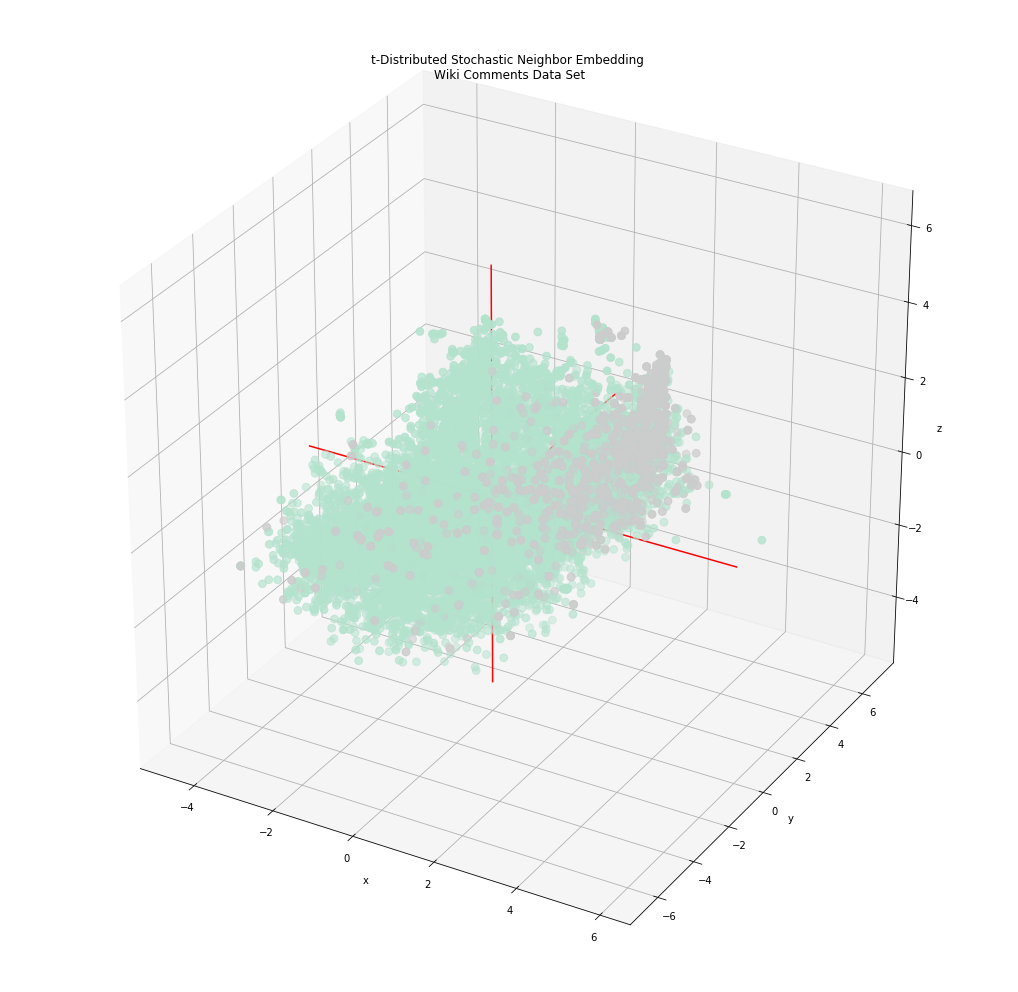

In [86]:
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=colors, cmap="Pastel2", s=60)

xAxisLine = ((min(x), max(x)), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(y), max(y)), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(z), max(z)))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("t-Distributed Stochastic Neighbor Embedding \nWiki Comments Data Set")
plt.show()


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, df.target)

In [39]:
svc = SVC()
svc.fit(X_train, y_train)

/Users/briansrebrenik/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

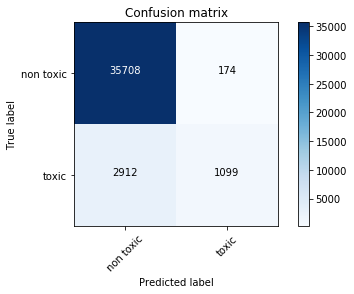

In [40]:
y_preds = svc.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_preds), classes=['non toxic', 'toxic'])

In [41]:
from sklearn.metrics import roc_curve, auc

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

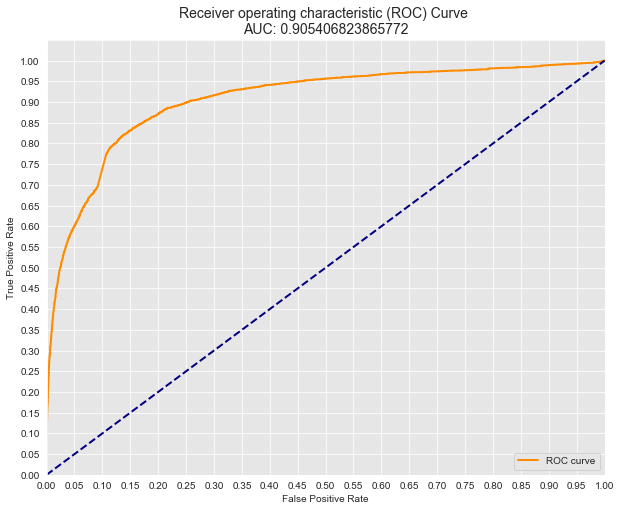

In [45]:
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic (ROC) Curve \nAUC: {auc(fpr, tpr)}', size=14)
plt.legend(loc="lower right")
plt.show()

###### info on pretrained embeddings with Keras: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [137]:
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, Conv1D, MaxPooling1D, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras import initializers, regularizers, constraints, optimizers, layers

In [200]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
texts = df.comment_text
tokenizer = Tokenizer(nb_words=20000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=100) #changed to 100 from 1000 for second nn

labels = to_categorical(np.asarray(df.target))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(.25 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

/Users/briansrebrenik/anaconda3/lib/python3.7/site-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 210337 unique tokens.
Shape of data tensor: (159571, 100)
Shape of label tensor: (159571, 2)


In [201]:
import os
embeddings_index = {}
f = open(os.path.join('./', 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [202]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [133]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=False)

In [140]:
sequence_input = Input(shape=(1000,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=128)

Train on 119679 samples, validate on 39892 samples
Epoch 1/2
119679/119679 [==============================] - 2234s 19ms/step - loss: 0.1632 - acc: 0.9428 - val_loss: 0.1291 - val_acc: 0.9526
Epoch 2/2
119679/119679 [==============================] - 2441s 20ms/step - loss: 0.1264 - acc: 0.9555 - val_loss: 0.1326 - val_acc: 0.9558


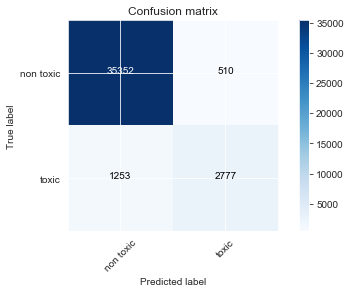

In [143]:
y_preds = model.predict(x_val)
y_preds =[x[1] for x in y_preds]
y_preds = [int(round(x)) for x in y_preds]
y_val = [x[1] for x in y_val]
plot_confusion_matrix(confusion_matrix(y_val, y_preds), classes=['non toxic', 'toxic'])

In [118]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 128)          2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 25)           15400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 25)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                1300      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
__________

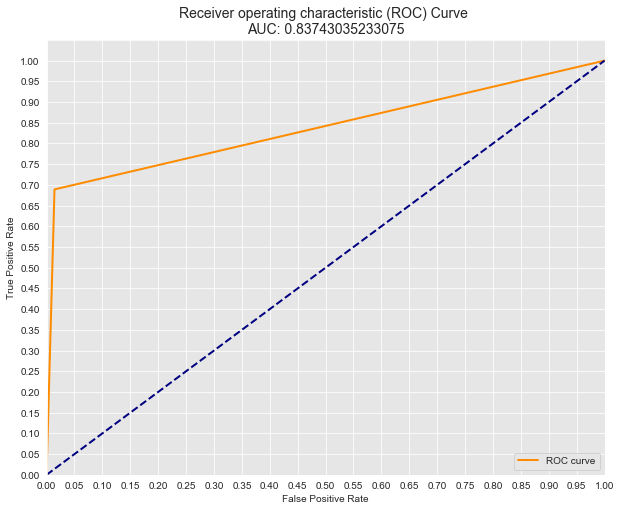

In [144]:
fpr, tpr, thresholds = roc_curve(y_val, y_preds)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic (ROC) Curve \nAUC: {auc(fpr, tpr)}', size=14)
plt.legend(loc="lower right")
plt.show()

In [203]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False)

In [204]:
sequence_input = Input(shape=(100,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(25, return_sequences=True)(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)

model = Model(inputs=sequence_input, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=5, batch_size=32)

Train on 119679 samples, validate on 39892 samples
Epoch 1/5
119679/119679 [==============================] - 387s 3ms/step - loss: 0.1726 - acc: 0.9410 - val_loss: 0.1163 - val_acc: 0.9584
Epoch 2/5
119679/119679 [==============================] - 373s 3ms/step - loss: 0.1382 - acc: 0.9522 - val_loss: 0.1159 - val_acc: 0.9574
Epoch 3/5
119679/119679 [==============================] - 395s 3ms/step - loss: 0.1286 - acc: 0.9551 - val_loss: 0.1125 - val_acc: 0.9578
Epoch 4/5
119679/119679 [==============================] - 391s 3ms/step - loss: 0.1234 - acc: 0.9572 - val_loss: 0.1102 - val_acc: 0.9595
Epoch 5/5
119679/119679 [==============================] - 378s 3ms/step - loss: 0.1192 - acc: 0.9574 - val_loss: 0.1103 - val_acc: 0.9568


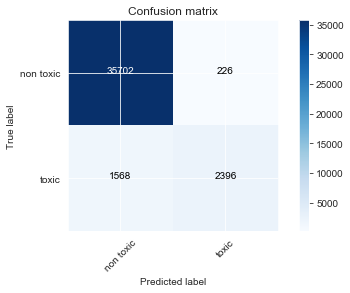

In [205]:
y_preds = model.predict(x_val)
y_preds =[x[1] for x in y_preds]
y_preds = [int(round(x)) for x in y_preds]
y_val = [x[1] for x in y_val]
plot_confusion_matrix(confusion_matrix(y_val, y_preds), classes=['non toxic', 'toxic'])

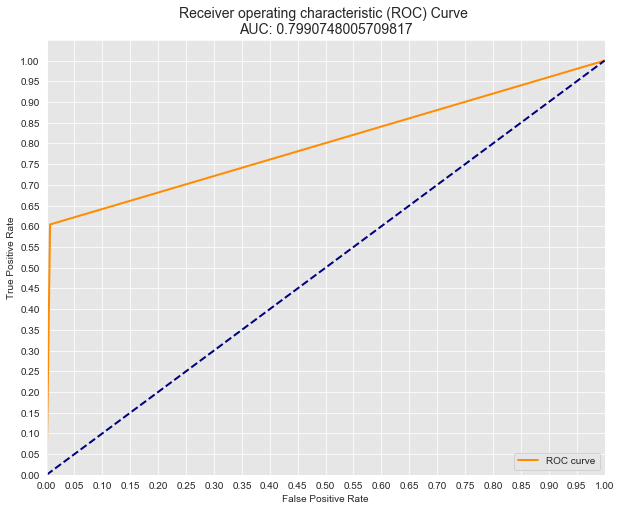

In [207]:
fpr, tpr, thresholds = roc_curve(y_val, y_preds)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic (ROC) Curve \nAUC: {auc(fpr, tpr)}', size=14)
plt.legend(loc="lower right")
plt.show()